In [1]:
%matplotlib inline
import pyspark
import pandas as pd
import math
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Normalizer
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql import SQLContext

In [2]:
sc = pyspark.SparkContext(master='local[*]')
sqlContext = SQLContext(sc)

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
shelter_pd = pd.read_csv('train.csv')

In [5]:
shelter_pd

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


## Data Analisis

In [6]:
shelter_pd.describe(include = "all")

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


El Data Quality Report nos da un análisis de los datos. Tenemos 26729 filas en el dataset y se puede ver que hay un missing value en la columna SexuponOutcome (<1%), 18 en AgeuponOutcome (<1%), 7691 en Name (~28.7%) y 13612 en OutcomeType(~50.9%).

Como vamos a manejar el problema de los missing values?

- En el caso de SexuponOutcome, podemos simplemente borrar las filas porque no va a afectar nuestro modelo de predicciones.
- En el caso de AgeuponOutcome, vamos a borrar las filas también porque son muy pocos datos (<1%).
- En el caso de Name, no nos importa porque no vamos a usar esa columna en nuestro modelo. (El nombre no influye el Outcome del animal..)
- En el caso de OutcomeSubtype, tenemos muchos missing value porque por algunos valores de OutcomeType, como por ejemplo <i>Return_to_owner</i>, no hacía falta poner más información.

Que tipo de transformaciones vamos a aplicar sobre los datos para que se pueda usar para crear un modelo de predicción?
- Name: Borramos la columna porque no nos interesa en nuestras predicciones.
- DateTime: Borramos la hora y el día porque no es relevante aquí y ponemos un incremental que empieza con el primer mes del dataset.
- OutcomeType: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- OutcomeSubtype: Borramos la columna porque no nos interesa en nuestras predicciones.
- AnimalType: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- SexuponOutcome: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- AgeuponOutcome: Vamos a convertir cada edad en semana para que todos los datos tengan la misma MEDIDA??
- Breed: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- Color: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.

Ahora vamos a limpiar los datos y transformar cada feature categórica a numérica para que se pueda usar para crear un modelo de predicción.

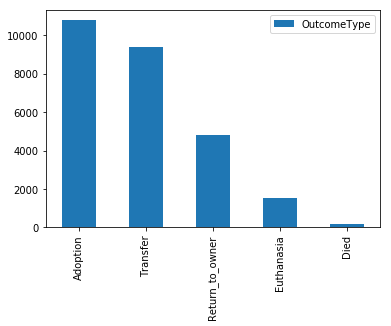

In [20]:
pd.DataFrame(shelter_pd.OutcomeType.value_counts()).plot(kind='bar')

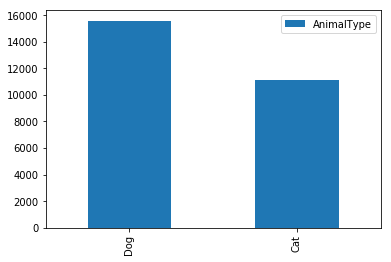

In [22]:
pd.DataFrame(shelter_pd.AnimalType.value_counts()).plot(kind='bar')

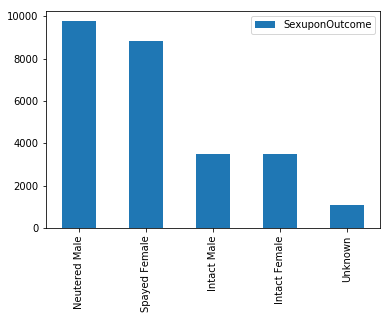

In [23]:
pd.DataFrame(shelter_pd.SexuponOutcome.value_counts()).plot(kind='bar')

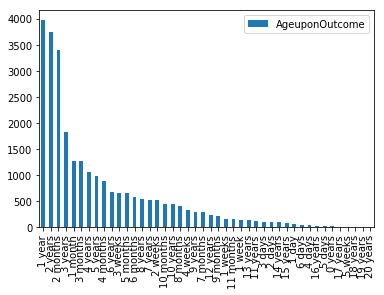

In [35]:
pd.DataFrame(shelter_pd['AgeuponOutcome'].value_counts()).plot(kind='bar')

### Part I: Cleaning the data

In [7]:
def valueCount(DF, column, value):## Function that counts the number of occurrences of a value in a given column
    count = 0
    columnIndex = DF.columns.get_loc(column)
    for (index, row) in DF.iterrows():
        if row[columnIndex] == value:
            count += 1
    return count

def missingValuesRemover(DF, column):## Removes the missing values in the given column
    count = 0
    columnIndex = DF.columns.get_loc(column)
    for (index, row) in DF.iterrows():
        if str(row[columnIndex]).lower().split() == ['nan']:
            DF = DF.drop(index)
            count += 1
    print(str(count) + " element(s) removed")
    return DF

NOTE:
- Should we normalise each feature in the range [0, 1]?

In [8]:
shelter_pd = missingValuesRemover(shelter_pd, "AgeuponOutcome")
shelter_pd = missingValuesRemover(shelter_pd, "SexuponOutcome")
del shelter_pd['AnimalID']
del shelter_pd['OutcomeSubtype']
del shelter_pd['Name']

18 element(s) removed
1 element(s) removed


### Part II: Indexation

In [9]:
shelter_pd[['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']] = shelter_pd[['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']].astype(str)
shelter_df = sqlContext.createDataFrame(shelter_pd)

## Creating a Spark Dataframe from the Pandas Dataframe in order to use it with the Decision Tree model.

In [10]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType


class AgeuponOutcomeTransformer(Transformer, HasInputCol, HasOutputCol): 
    # Does binning using the module of the division
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(AgeuponOutcomeTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: category_func(x), StringType())
        return dataset.withColumn(out_col, udf(in_col))

def category_func(in_value):
    if (in_value):
        age_in_days = 0
        splited_value = in_value.split(' ')        
        if (splited_value[1] == 'years' or splited_value[1] == 'year'):
            age_in_days = int(splited_value[0])*365
        elif(splited_value[1] == 'months' or splited_value[1] == 'month'):
            age_in_days = int(splited_value[0])*30
        elif(splited_value[1] == 'weeks' or splited_value[1] == 'week'):
            age_in_days = int(splited_value[0])*7
                
        if (age_in_days > 0 and age_in_days <= 365):
            return 'young'
        elif (age_in_days > 365 and age_in_days <= 365*3):
            return 'young_adult'
        elif (age_in_days > 365*3 and age_in_days <= 365*7):
            return 'adult'
        elif (age_in_days > 365*7 and age_in_days <= 365*10):
            return 'old_adult'
        elif (age_in_days > 365*10):
            return 'old'
    else:
        return 'None'

In [11]:
class BinningTransformer(Transformer, HasInputCol, HasOutputCol): 
    # Does binning using the module of the division
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(BinningTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: bin_func(x), DoubleType())
        return dataset.withColumn(out_col, udf(in_col))

def bin_func(in_value):
    if (in_value):
        age_in_days = 0
        splited_value = in_value.split(' ')        
        if (splited_value[1] == 'years' or splited_value[1] == 'year'):
            age_in_days = int(splited_value[0])*365
        elif(splited_value[1] == 'months' or splited_value[1] == 'month'):
            age_in_days = int(splited_value[0])*30
        elif(splited_value[1] == 'weeks' or splited_value[1] == 'week'):
            age_in_days = int(splited_value[0])*7
                
        if (age_in_days > 0 and age_in_days <= 365):
            return 1.0
        elif (age_in_days > 365 and age_in_days <= 365*3):
            return 2.0
        elif (age_in_days > 365*3 and age_in_days <= 365*7):
            return 3.0
        elif (age_in_days > 365*7 and age_in_days <= 365*10):
            return 4.0
        elif (age_in_days > 365*10):
            return 5.0
    else:
        return 0.0

In [12]:
## Here are all the indexers we're gonna use in the pipeline:
OutcomeType_indexer = StringIndexer(inputCol="OutcomeType", outputCol="OutcomeType_idx")
AnimalType_indexer = StringIndexer(inputCol="AnimalType", outputCol="AnimalType_idx")
SexuponOutcome_indexer = StringIndexer(inputCol="SexuponOutcome", outputCol="SexuponOutcome_idx")
Breed_indexer = StringIndexer(inputCol="Breed", outputCol="Breed_idx")
Color_indexer = StringIndexer(inputCol="Color", outputCol="Color_idx")
#Age_indexer = StringIndexer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_idx')
Bin_transformer = BinningTransformer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_binned')
AgeuponOutcome_transformer = AgeuponOutcomeTransformer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_category')


## Should we use OneHotEncoder or StringIndexer for continuous features?
## It looks like we're using StringIndexer more for stuff like boolean values and
## OneHotEncoder for actual categorical features.. But not sure
## Anyway if it's actally OneHotEncoder that we need to use, we just need to add
## One OneHotIndexer and use the OutcomeType_idx we just created as inputCol..

In [13]:
pipeline = Pipeline(stages=[OutcomeType_indexer, AnimalType_indexer, SexuponOutcome_indexer, Breed_indexer, Color_indexer, AgeuponOutcome_transformer, Bin_transformer])
model = pipeline.fit(shelter_df)

In [14]:
shelter_df_idx = model.transform(shelter_df)
shelter_df_idx.show()

+-------------------+---------------+----------+--------------+--------------+--------------------+------------------+---------------+--------------+------------------+---------+---------+-----------------------+---------------------+
|           DateTime|    OutcomeType|AnimalType|SexuponOutcome|AgeuponOutcome|               Breed|             Color|OutcomeType_idx|AnimalType_idx|SexuponOutcome_idx|Breed_idx|Color_idx|AgeuponOutcome_category|AgeuponOutcome_binned|
+-------------------+---------------+----------+--------------+--------------+--------------------+------------------+---------------+--------------+------------------+---------+---------+-----------------------+---------------------+
|2014-02-12 18:22:00|Return_to_owner|       Dog| Neutered Male|        1 year|Shetland Sheepdog...|       Brown/White|            2.0|           0.0|               0.0|    100.0|      5.0|                  young|                  1.0|
|2013-10-13 12:44:00|     Euthanasia|       Cat| Spayed Fema

In [15]:
shelter_df_only_idx = shelter_df_idx
shelter_df_only_idx = shelter_df_only_idx.drop('OutcomeType', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color')

## Dropping the tables that are still categorical because they're no use to us.

In [16]:
shelter_df_only_idx.registerTempTable("shelter")
sqlContext.sql("SELECT OutcomeType_idx, AnimalType_idx, SexuponOutcome_idx, Breed_idx, Color_idx, AgeuponOutcome_binned FROM shelter").show()

## Showing all the indexed tables

+---------------+--------------+------------------+---------+---------+---------------------+
|OutcomeType_idx|AnimalType_idx|SexuponOutcome_idx|Breed_idx|Color_idx|AgeuponOutcome_binned|
+---------------+--------------+------------------+---------+---------+---------------------+
|            2.0|           0.0|               0.0|    100.0|      5.0|                  1.0|
|            3.0|           1.0|               1.0|      0.0|     32.0|                  1.0|
|            0.0|           0.0|               0.0|      1.0|      9.0|                  2.0|
|            1.0|           1.0|               2.0|      0.0|    122.0|                  1.0|
|            1.0|           0.0|               0.0|    281.0|     13.0|                  2.0|
|            1.0|           0.0|               3.0|    152.0|     10.0|                  1.0|
|            1.0|           1.0|               2.0|      0.0|     21.0|                  1.0|
|            1.0|           1.0|               4.0|      0.0

#################################
#################################


OKAY GUYS, 

Tenemos que cambiar la columna fecha y edad para poder usarlo con decision tree


#################################
#################################

### Para realizar naive base convertimos el cleaned dataframe de spark a pandas

In [17]:
shelter_df_only_category = shelter_df_idx
shelter_df_only_category = shelter_df_only_category.drop('DateTime', 'OutcomeType_idx', 'AnimalType_idx', 'SexuponOutcome_idx', 'Breed_idx', 'Color_idx','AgeuponOutcome_binned', 'Ageuponoutcome')
shelter_cleaned_df = shelter_df_only_category.toPandas()
shelter_cleaned_df

,OutcomeType,AnimalType,SexuponOutcome,Breed,Color,AgeuponOutcome_category
0,Return_to_owner,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,young
1,Euthanasia,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,young
2,Adoption,Dog,Neutered Male,Pit Bull Mix,Blue/White,young_adult
3,Transfer,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,young
4,Transfer,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,young_adult
5,Transfer,Dog,Intact Female,Cairn Terrier/Chihuahua Shorthair,Black/Tan,young
6,Transfer,Cat,Intact Male,Domestic Shorthair Mix,Blue Tabby,young
7,Transfer,Cat,Unknown,Domestic Shorthair Mix,Brown Tabby,young
8,Adoption,Dog,Spayed Female,American Pit Bull Terrier Mix,Red/White,young
9,Adoption,Dog,Spayed Female,Cairn Terrier,White,young
